License

```
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
```

# Using CompilerGym environments with RLlib

In this notebook we will use [RLlib](https://docs.ray.io/en/master/rllib.html) to train an agent for CompilerGym's [LLVM environment](https://facebookresearch.github.io/CompilerGym/llvm/index.html). RLlib is a popular library for scalable reinforcement learning, built on [Ray](https://docs.ray.io/en/master/index.html). It provides distributed implementations of several standard reinforcement learning algorithms.

Our goal is not to produce the best agent, but to demonstrate how to integrate CompilerGym with RLlib. It will take about 20 minutes to work through. Let's get started!

## Installation

We'll begin by installing the `compiler_gym` and `ray` packages:

In [1]:
!pip install compiler_gym 'ray[default,rllib]' &>/dev/null || echo "Install failed!"

# Print the versions of the libraries that we are using:
import compiler_gym
import ray

print("compiler_gym version:", compiler_gym.__version__)
print("ray version:", ray.__version__)

compiler_gym version: 0.1.9
ray version: 1.3.0


## Defining an Environment

Next we will define the environment to use for our experiments. For the purposes of a simple demo we will apply two simplifying constraints to CompilerGym's LLVM environment:

1. We will use only a small subset of the command line flag action space.
2. We will clip the length of episodes to a maximum number of steps.

To make things simple we will define a `make_env()` helper function to create our environment, and use the [compiler_gym.wrappers](https://facebookresearch.github.io/CompilerGym/compiler_gym/wrappers.html) API to implement these constraints. There is quite a lot going on in this cell, be sure to read through the comments for an explanation of what is going on!

In [2]:
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit
from ray import tune

def make_env() -> compiler_gym.envs.CompilerEnv:
    """Make the reinforcement learning environment for this experiment."""
    # We will use LLVM as our base environment. Here we specify the observation
    # space from this paper: https://arxiv.org/pdf/2003.00671.pdf and the total
    # IR instruction count as our reward space, normalized against the 
    # performance of LLVM's -Oz policy.
    env = compiler_gym.make(
        "llvm-v0",
        observation_space="Autophase",
        reward_space="IrInstructionCountOz",
    )
    # Here we constrain the action space of the environment to use only a 
    # handful of command line flags from the full set. We do this to speed up
    # learning by pruning the action space by hand. This also limits the 
    # potential improvements that the agent can achieve compared to using the 
    # full action space.
    env = ConstrainedCommandline(env, flags=[
        "-break-crit-edges",
        "-early-cse-memssa",
        "-gvn-hoist",
        "-gvn",
        "-instcombine",
        "-instsimplify",
        "-jump-threading",
        "-loop-reduce",
        "-loop-rotate",
        "-loop-versioning",
        "-mem2reg",
        "-newgvn",
        "-reg2mem",
        "-simplifycfg",
        "-sroa",
    ])
    # Finally, we impose a time limit on the environment so that every episode
    # for 5 steps or fewer. This is because the environment's task is continuous
    # and no action is guaranteed to result in a terminal state. Adding a time
    # limit means we don't have to worry about learning when an agent should 
    # stop, though again this limits the potential improvements that the agent
    # can achieve compared to using an unbounded maximum episode length.
    env = TimeLimit(env, max_episode_steps=5)
    return env

In [3]:
# Let's create an environment and print a few attributes just to check that we 
# have everything set up the way that we would like.
with make_env() as env:
    print("Action space:", env.action_space)
    print("Observation space:", env.observation_space)
    print("Reward space:", env.reward_space)

Action space: Commandline([-break-crit-edges -early-cse-memssa -gvn-hoist -gvn -instcombine -instsimplify -jump-threading -loop-reduce -loop-rotate -loop-versioning -mem2reg -newgvn -reg2mem -simplifycfg -sroa])
Observation space: Box(0, 9223372036854775807, (56,), int64)
Reward space: IrInstructionCountOz


## Datasets

Now that we have an environment, we will need a set of programs to train on. In CompilerGym, these programs are called *benchmarks*. CompilerGym ships with [several sets of benchmarks](https://facebookresearch.github.io/CompilerGym/llvm/index.html#datasets). Here we will take a handful of benchmarks from the `npb-v0` dataset for training. We will then further divide this set into training and validation sets. We will use `chstone-v0` as a holdout test set.

In [4]:
from itertools import islice

with make_env() as env:
  # The two datasets we will be using:
  npb = env.datasets["npb-v0"]
  chstone = env.datasets["chstone-v0"]

  # Each dataset has a `benchmarks()` method that returns an iterator over the
  # benchmarks within the dataset. Here we will use iterator sliceing to grab a 
  # handful of benchmarks for training and validation.
  train_benchmarks = list(islice(npb.benchmarks(), 55))
  train_benchmarks, val_benchmarks = train_benchmarks[:50], train_benchmarks[50:]
  # We will use the entire chstone-v0 dataset for testing.
  test_benchmarks = list(chstone.benchmarks())

print("Number of benchmarks for training:", len(train_benchmarks))
print("Number of benchmarks for validation:", len(val_benchmarks))
print("Number of benchmarks for testing:", len(test_benchmarks))

Number of benchmarks for training: 50
Number of benchmarks for validation: 5
Number of benchmarks for testing: 12


## Registering the environment with RLlib

Now that we have our environment and training benchmarks, we can register the environment for use with RLlib. To do this we will define a second `make_training_env()` helper that uses the [CycleOverBenchmarks](https://facebookresearch.github.io/CompilerGym/compiler_gym/wrappers.html#compiler_gym.wrappers.CycleOverBenchmarks) wrapper to ensure that the environment uses all of the training benchmarks. We then call `tune.register_env()`, assining the environment a name.

In [5]:
from compiler_gym.wrappers import CycleOverBenchmarks

def make_training_env(*args) -> compiler_gym.envs.CompilerEnv:
  """Make a reinforcement learning environment that cycles over the
  set of training benchmarks in use.
  """
  del args  # Unused env_config argument passed by ray
  return CycleOverBenchmarks(make_env(), train_benchmarks)

tune.register_env("compiler_gym", make_training_env)

In [6]:
# Lets cycle through a few calls to reset() to demonstrate that this environment
# selects a new benchmark for each episode.
with make_training_env() as env:
  env.reset()
  print(env.benchmark)
  env.reset()
  print(env.benchmark)
  env.reset()
  print(env.benchmark)

benchmark://npb-v0/1
benchmark://npb-v0/2
benchmark://npb-v0/3


## Run the training loop

Now that we have the environment set up, let's run a training loop. Here will use RLlib's [Proximal Policy Optimization](https://docs.ray.io/en/master/rllib-algorithms.html#ppo) implementation, and run a very short training loop just for demonstative purposes.

In [7]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

# (Re)Start the ray runtime.
if ray.is_initialized():
  ray.shutdown()
ray.init(include_dashboard=False, ignore_reinit_error=True)

tune.register_env("compiler_gym", make_training_env)

analysis = tune.run(
    PPOTrainer,
    checkpoint_at_end=True,
    stop={
        "episodes_total": 500,
    },
    config={
        "seed": 0xCC,
        "num_workers": 1,
        # Specify the environment to use, where "compiler_gym" is the name we 
        # passed to tune.register_env().
        "env": "compiler_gym",
        # Reduce the size of the batch/trajectory lengths to match our short 
        # training run.
        "rollout_fragment_length": 5,
        "train_batch_size": 5,
        "sgd_minibatch_size": 5,
    }
)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


Trial name,status,loc
PPO_compiler_gym_6c005_00000,RUNNING,


(pid=9274) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=9274) Instructions for updating:
(pid=9274) non-resource variables are not supported in the long term
(pid=9274) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/variadic_reduce.py:115: calling function (from tensorflow.python.eager.def_function) with experimental_compile is deprecated and will be removed in a future version.
(pid=9274) Instructions for updating:
(pid=9274) experimental_compile is deprecated, use jit_compile instead
(pid=9274) 2021-06-04 16:03:42,146	INFO trainer.py:669 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=9274) 2021-06-04 16:03:42,146	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': '

Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 5
  custom_metrics: {}
  date: 2021-06-04_16-03-49
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.4069767441860465
  episode_reward_mean: 0.4069767441860465
  episode_reward_min: 0.4069767441860465
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 2.7013802528381348
          entropy_coeff: 0.0
          kl: 0.006312782876193523
          model: {}
          policy_loss: -0.18230918049812317
          total_loss: -0.15246529877185822
          vf_explained_var: 0.16006684303283691
          vf_loss: 0.028581315651535988
    num_agent_steps_sampled: 5
    num_steps_sampled: 5
    num_steps_trained: 5
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,1,0.59376,5,0.406977,0.406977,0.406977,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 75
  custom_metrics: {}
  date: 2021-06-04_16-03-54
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 9.431818181818182
  episode_reward_mean: 1.2791555852475684
  episode_reward_min: -0.08085106382978724
  episodes_this_iter: 1
  episodes_total: 15
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.708593726158142
          cur_lr: 4.999999873689376e-05
          entropy: 2.366990566253662
          entropy_coeff: 0.0
          kl: 0.015009311959147453
          model: {}
          policy_loss: -0.2545779347419739
          total_loss: 0.18985310196876526
          vf_explained_var: 0.0
          vf_loss: 0.4187861979007721
    num_agent_steps_sampled: 75
    num_steps_sampled: 75
    num_steps_trained: 75
  iterations_since_restore: 15
  node_ip: 172.28.0.2
  num_healthy_work

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,15,5.46108,75,1.27916,9.43182,-0.0808511,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 145
  custom_metrics: {}
  date: 2021-06-04_16-03-59
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 9.431818181818182
  episode_reward_mean: -0.8422814711871025
  episode_reward_min: -52.0
  episodes_this_iter: 1
  episodes_total: 29
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 4.324877738952637
          cur_lr: 4.999999873689376e-05
          entropy: 2.3182315826416016
          entropy_coeff: 0.0
          kl: 0.010489774867892265
          model: {}
          policy_loss: -0.20667710900306702
          total_loss: 0.3873479962348938
          vf_explained_var: 0.49481141567230225
          vf_loss: 0.5486580729484558
    num_agent_steps_sampled: 145
    num_steps_sampled: 145
    num_steps_trained: 145
  iterations_since_restore: 29
  node_ip: 172.28.0.2
  num_healt

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,29,10.3975,145,-0.842281,9.43182,-52,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 215
  custom_metrics: {}
  date: 2021-06-04_16-04-05
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 3.394686556111372
  episode_reward_min: -52.0
  episodes_this_iter: 1
  episodes_total: 43
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 3.2436585426330566
          cur_lr: 4.999999873689376e-05
          entropy: 2.3825843334198
          entropy_coeff: 0.0
          kl: 0.022935297340154648
          model: {}
          policy_loss: -0.2687135636806488
          total_loss: 0.24539396166801453
          vf_explained_var: 0.6805019378662109
          vf_loss: 0.4397132992744446
    num_agent_steps_sampled: 215
    num_steps_sampled: 215
    num_steps_trained: 215
  iterations_since_restore: 43
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  o

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,43,15.1409,215,3.39469,159,-52,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 305
  custom_metrics: {}
  date: 2021-06-04_16-04-10
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 2.886634196406002
  episode_reward_min: -52.0
  episodes_this_iter: 1
  episodes_total: 61
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 3.649115800857544
          cur_lr: 4.999999873689376e-05
          entropy: 2.1408872604370117
          entropy_coeff: 0.0
          kl: 0.007102621253579855
          model: {}
          policy_loss: -0.21200492978096008
          total_loss: 0.2864999771118164
          vf_explained_var: 0.7792697548866272
          vf_loss: 0.4725866913795471
    num_agent_steps_sampled: 305
    num_steps_sampled: 305
    num_steps_trained: 305
  iterations_since_restore: 61
  node_ip: 172.28.0.2
  num_healthy_workers: 1
 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,61,19.7971,305,2.88663,159,-52,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 415
  custom_metrics: {}
  date: 2021-06-04_16-04-15
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 4.267204983307606
  episode_reward_min: -52.0
  episodes_this_iter: 1
  episodes_total: 83
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 5.4736738204956055
          cur_lr: 4.999999873689376e-05
          entropy: 1.9793866872787476
          entropy_coeff: 0.0
          kl: 0.003541119396686554
          model: {}
          policy_loss: -0.11942613124847412
          total_loss: 0.10622720420360565
          vf_explained_var: 0.6420673131942749
          vf_loss: 0.20627036690711975
    num_agent_steps_sampled: 415
    num_steps_sampled: 415
    num_steps_trained: 415
  iterations_since_restore: 83
  node_ip: 172.28.0.2
  num_healthy_workers: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,83,24.5159,415,4.2672,159,-52,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 525
  custom_metrics: {}
  date: 2021-06-04_16-04-20
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 4.664450347937849
  episode_reward_min: -52.0
  episodes_this_iter: 1
  episodes_total: 105
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.1546030044555664
          cur_lr: 4.999999873689376e-05
          entropy: 1.6399190425872803
          entropy_coeff: 0.0
          kl: 0.021851975470781326
          model: {}
          policy_loss: -0.1908329874277115
          total_loss: -0.16160084307193756
          vf_explained_var: 0.9634737968444824
          vf_loss: 0.004001783672720194
    num_agent_steps_sampled: 525
    num_steps_sampled: 525
    num_steps_trained: 525
  iterations_since_restore: 105
  node_ip: 172.28.0.2
  num_healthy_worker

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,105,29.1363,525,4.66445,159,-52,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 635
  custom_metrics: {}
  date: 2021-06-04_16-04-25
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 6.085601770717566
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 127
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.4659345149993896
          cur_lr: 4.999999873689376e-05
          entropy: 1.619084119796753
          entropy_coeff: 0.0
          kl: 0.006216425448656082
          model: {}
          policy_loss: -0.047797299921512604
          total_loss: -0.005831587128341198
          vf_explained_var: 0.9922365546226501
          vf_loss: 0.026636406779289246
    num_agent_steps_sampled: 635
    num_steps_sampled: 635
    num_steps_trained: 635
  iterations_since_restore: 127
  node_ip: 172.28.0.2
  num_healthy_worke

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,127,33.8085,635,6.0856,159,-2,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 740
  custom_metrics: {}
  date: 2021-06-04_16-04-30
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 153.0
  episode_reward_mean: 5.397098575733069
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 148
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.21944166719913483
          cur_lr: 4.999999873689376e-05
          entropy: 0.6173404455184937
          entropy_coeff: 0.0
          kl: 0.0002538803964853287
          model: {}
          policy_loss: -0.008465206250548363
          total_loss: 2.2837562561035156
          vf_explained_var: -0.3163095712661743
          vf_loss: 2.292165756225586
    num_agent_steps_sampled: 740
    num_steps_sampled: 740
    num_steps_trained: 740
  iterations_since_restore: 148
  node_ip: 172.28.0.2
  num_healthy_workers

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,148,38.3968,740,5.3971,153,-2,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 845
  custom_metrics: {}
  date: 2021-06-04_16-04-36
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 5.4284459237557
  episode_reward_min: 0.0
  episodes_this_iter: 1
  episodes_total: 169
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.005492236465215683
          cur_lr: 4.999999873689376e-05
          entropy: 2.13354754447937
          entropy_coeff: 0.0
          kl: 0.046996910125017166
          model: {}
          policy_loss: -0.14283575117588043
          total_loss: 3.297272205352783
          vf_explained_var: 0.9391043782234192
          vf_loss: 3.439849853515625
    num_agent_steps_sampled: 845
    num_steps_sampled: 845
    num_steps_trained: 845
  iterations_since_restore: 169
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  of

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,169,43.1004,845,5.42845,159,0,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 950
  custom_metrics: {}
  date: 2021-06-04_16-04-41
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 5.438693288465101
  episode_reward_min: -0.007751937984496124
  episodes_this_iter: 1
  episodes_total: 190
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.4050166606903076
          cur_lr: 4.999999873689376e-05
          entropy: 1.4306457042694092
          entropy_coeff: 0.0
          kl: 0.02172720432281494
          model: {}
          policy_loss: -0.1413513869047165
          total_loss: 0.332834392786026
          vf_explained_var: -1.0
          vf_loss: 0.42193156480789185
    num_agent_steps_sampled: 950
    num_steps_sampled: 950
    num_steps_trained: 950
  iterations_since_restore: 190
  node_ip: 172.28.0.2
  num_healthy_workers: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,190,47.8091,950,5.43869,159,-0.00775194,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1055
  custom_metrics: {}
  date: 2021-06-04_16-04-46
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 5.449550297250294
  episode_reward_min: -0.007751937984496124
  episodes_this_iter: 1
  episodes_total: 211
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.705643892288208
          cur_lr: 4.999999873689376e-05
          entropy: 1.3432374000549316
          entropy_coeff: 0.0
          kl: 0.00826875027269125
          model: {}
          policy_loss: -0.17243722081184387
          total_loss: 1.9828155040740967
          vf_explained_var: -1.0
          vf_loss: 2.132880449295044
    num_agent_steps_sampled: 1055
    num_steps_sampled: 1055
    num_steps_trained: 1055
  iterations_since_restore: 211
  node_ip: 172.28.0.2
  num_healthy_worker

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,211,52.4529,1055,5.44955,159,-0.00775194,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1160
  custom_metrics: {}
  date: 2021-06-04_16-04-51
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 6.0502116898276315
  episode_reward_min: -0.007751937984496124
  episodes_this_iter: 1
  episodes_total: 232
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.5682477951049805
          cur_lr: 4.999999873689376e-05
          entropy: 2.201913356781006
          entropy_coeff: 0.0
          kl: 0.023324552923440933
          model: {}
          policy_loss: -0.17493696510791779
          total_loss: 0.24101801216602325
          vf_explained_var: 0.953052818775177
          vf_loss: 0.3560517430305481
    num_agent_steps_sampled: 1160
    num_steps_sampled: 1160
    num_steps_trained: 1160
  iterations_since_restore: 232
  node_ip: 172.28.0.2
  n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,232,57.1815,1160,6.05021,159,-0.00775194,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1260
  custom_metrics: {}
  date: 2021-06-04_16-04-56
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 159.0
  episode_reward_mean: 6.087637708895921
  episode_reward_min: -0.007751937984496124
  episodes_this_iter: 1
  episodes_total: 252
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.60945725440979
          cur_lr: 4.999999873689376e-05
          entropy: 1.3165415525436401
          entropy_coeff: 0.0
          kl: 0.010732493363320827
          model: {}
          policy_loss: -0.14077933132648468
          total_loss: -0.06813585758209229
          vf_explained_var: 0.812760055065155
          vf_loss: 0.06610246747732162
    num_agent_steps_sampled: 1260
    num_steps_sampled: 1260
    num_steps_trained: 1260
  iterations_since_restore: 252
  node_ip: 172.28.0.2
  n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,252,61.7464,1260,6.08764,159,-0.00775194,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1360
  custom_metrics: {}
  date: 2021-06-04_16-05-01
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 150.0
  episode_reward_mean: 5.790035518450664
  episode_reward_min: -0.007751937984496124
  episodes_this_iter: 1
  episodes_total: 272
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.36608725786209106
          cur_lr: 4.999999873689376e-05
          entropy: 0.8189104795455933
          entropy_coeff: 0.0
          kl: 0.009806491434574127
          model: {}
          policy_loss: -0.09162213653326035
          total_loss: 47.403053283691406
          vf_explained_var: -1.0
          vf_loss: 47.491085052490234
    num_agent_steps_sampled: 1360
    num_steps_sampled: 1360
    num_steps_trained: 1360
  iterations_since_restore: 272
  node_ip: 172.28.0.2
  num_healthy_wo

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,272,66.4153,1360,5.79004,150,-0.00775194,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1455
  custom_metrics: {}
  date: 2021-06-04_16-05-06
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 150.0
  episode_reward_mean: 5.866413579548341
  episode_reward_min: -0.1410459587955626
  episodes_this_iter: 1
  episodes_total: 291
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.32985055446624756
          cur_lr: 4.999999873689376e-05
          entropy: 0.4789682924747467
          entropy_coeff: 0.0
          kl: 0.004818943329155445
          model: {}
          policy_loss: -0.03120868280529976
          total_loss: 0.35436782240867615
          vf_explained_var: -1.0
          vf_loss: 0.3839869797229767
    num_agent_steps_sampled: 1455
    num_steps_sampled: 1455
    num_steps_trained: 1455
  iterations_since_restore: 291
  node_ip: 172.28.0.2
  num_healthy_wor

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,291,70.9797,1455,5.86641,150,-0.141046,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1550
  custom_metrics: {}
  date: 2021-06-04_16-05-11
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 150.0
  episode_reward_mean: 5.751158095733486
  episode_reward_min: -0.1410459587955626
  episodes_this_iter: 1
  episodes_total: 310
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.0036691445857286453
          cur_lr: 4.999999873689376e-05
          entropy: 0.470235675573349
          entropy_coeff: 0.0
          kl: 0.001588011858984828
          model: {}
          policy_loss: -0.004791200160980225
          total_loss: 0.2742980122566223
          vf_explained_var: -1.0
          vf_loss: 0.27908334136009216
    num_agent_steps_sampled: 1550
    num_steps_sampled: 1550
    num_steps_trained: 1550
  iterations_since_restore: 310
  node_ip: 172.28.0.2
  num_healthy_w

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,310,75.6047,1550,5.75116,150,-0.141046,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1645
  custom_metrics: {}
  date: 2021-06-04_16-05-17
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 137.0
  episode_reward_mean: 5.583295153334322
  episode_reward_min: -0.1410459587955626
  episodes_this_iter: 1
  episodes_total: 329
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.040715298790019e-05
          cur_lr: 4.999999873689376e-05
          entropy: 0.21518540382385254
          entropy_coeff: 0.0
          kl: 0.00010625070717651397
          model: {}
          policy_loss: -0.0017164051532745361
          total_loss: 0.142826110124588
          vf_explained_var: -1.0
          vf_loss: 0.14454251527786255
    num_agent_steps_sampled: 1645
    num_steps_sampled: 1645
    num_steps_trained: 1645
  iterations_since_restore: 329
  node_ip: 172.28.0.2
  num_healt

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,329,80.2361,1645,5.5833,137,-0.141046,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1740
  custom_metrics: {}
  date: 2021-06-04_16-05-22
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 137.0
  episode_reward_mean: 5.57863223511298
  episode_reward_min: -0.1410459587955626
  episodes_this_iter: 1
  episodes_total: 348
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.0004964537802152336
          cur_lr: 4.999999873689376e-05
          entropy: 1.8982102870941162
          entropy_coeff: 0.0
          kl: 0.06140489503741264
          model: {}
          policy_loss: -0.21536441147327423
          total_loss: 0.24268946051597595
          vf_explained_var: -0.25807809829711914
          vf_loss: 0.45802339911460876
    num_agent_steps_sampled: 1740
    num_steps_sampled: 1740
    num_steps_trained: 1740
  iterations_since_restore: 348
  node_ip: 172.28.0.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,348,84.8711,1740,5.57863,137,-0.141046,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1835
  custom_metrics: {}
  date: 2021-06-04_16-05-27
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 137.0
  episode_reward_mean: 5.579650977943752
  episode_reward_min: -0.1410459587955626
  episodes_this_iter: 1
  episodes_total: 367
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.04076138883829117
          cur_lr: 4.999999873689376e-05
          entropy: 0.4651680886745453
          entropy_coeff: 0.0
          kl: 0.05377843230962753
          model: {}
          policy_loss: -0.11333165317773819
          total_loss: -0.0398925319314003
          vf_explained_var: -0.546963095664978
          vf_loss: 0.07124700397253036
    num_agent_steps_sampled: 1835
    num_steps_sampled: 1835
    num_steps_trained: 1835
  iterations_since_restore: 367
  node_ip: 172.28.0.2
  n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,367,89.5777,1835,5.57965,137,-0.141046,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 1930
  custom_metrics: {}
  date: 2021-06-04_16-05-32
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 137.0
  episode_reward_mean: 5.896319899779285
  episode_reward_min: -0.2
  episodes_this_iter: 1
  episodes_total: 386
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.9832403659820557
          cur_lr: 4.999999873689376e-05
          entropy: 1.1040265560150146
          entropy_coeff: 0.0
          kl: 0.02567962370812893
          model: {}
          policy_loss: -0.17617864906787872
          total_loss: 2713.349609375
          vf_explained_var: 0.2836701273918152
          vf_loss: 2713.47509765625
    num_agent_steps_sampled: 1930
    num_steps_sampled: 1930
    num_steps_trained: 1930
  iterations_since_restore: 386
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,386,94.305,1930,5.89632,137,-0.2,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2025
  custom_metrics: {}
  date: 2021-06-04_16-05-37
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 137.0
  episode_reward_mean: 5.956194729287258
  episode_reward_min: -0.2
  episodes_this_iter: 1
  episodes_total: 405
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.8825289011001587
          cur_lr: 4.999999873689376e-05
          entropy: 0.8675780296325684
          entropy_coeff: 0.0
          kl: 0.018008893355727196
          model: {}
          policy_loss: -0.11954104900360107
          total_loss: 0.0023887394927442074
          vf_explained_var: 0.168523371219635
          vf_loss: 0.08802751451730728
    num_agent_steps_sampled: 2025
    num_steps_sampled: 2025
    num_steps_trained: 2025
  iterations_since_restore: 405
  node_ip: 172.28.0.2
  num_healthy_wor

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,405,99.0972,2025,5.95619,137,-0.2,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2115
  custom_metrics: {}
  date: 2021-06-04_16-05-42
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 144.0
  episode_reward_mean: 6.056504108012375
  episode_reward_min: -0.2
  episodes_this_iter: 1
  episodes_total: 423
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 3.5738635063171387
          cur_lr: 4.999999873689376e-05
          entropy: 1.8488719463348389
          entropy_coeff: 0.0
          kl: 0.016675403341650963
          model: {}
          policy_loss: -0.18986190855503082
          total_loss: 1.1526296138763428
          vf_explained_var: -1.0
          vf_loss: 1.2828959226608276
    num_agent_steps_sampled: 2115
    num_steps_sampled: 2115
    num_steps_trained: 2115
  iterations_since_restore: 423
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_pol

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,423,103.7,2115,6.0565,144,-0.2,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2205
  custom_metrics: {}
  date: 2021-06-04_16-05-47
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 144.0
  episode_reward_mean: 5.856204418141635
  episode_reward_min: -0.39999999999999997
  episodes_this_iter: 1
  episodes_total: 441
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.6803975105285645
          cur_lr: 4.999999873689376e-05
          entropy: 1.3643990755081177
          entropy_coeff: 0.0
          kl: 0.007421419024467468
          model: {}
          policy_loss: -0.15393026173114777
          total_loss: 0.5875455737113953
          vf_explained_var: -0.7447265386581421
          vf_loss: 0.7215834856033325
    num_agent_steps_sampled: 2205
    num_steps_sampled: 2205
    num_steps_trained: 2205
  iterations_since_restore: 441
  node_ip: 172.28.0.2
  n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,441,108.388,2205,5.8562,144,-0.4,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2295
  custom_metrics: {}
  date: 2021-06-04_16-05-53
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 144.0
  episode_reward_mean: 5.872443859852986
  episode_reward_min: -0.39999999999999997
  episodes_this_iter: 1
  episodes_total: 459
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 4.5231709480285645
          cur_lr: 4.999999873689376e-05
          entropy: 2.0307698249816895
          entropy_coeff: 0.0
          kl: 0.010831372812390327
          model: {}
          policy_loss: -0.10823900997638702
          total_loss: -0.05384896323084831
          vf_explained_var: 0.9740583300590515
          vf_loss: 0.0053978837095201015
    num_agent_steps_sampled: 2295
    num_steps_sampled: 2295
    num_steps_trained: 2295
  iterations_since_restore: 459
  node_ip: 172.28.0.2

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,459,113.089,2295,5.87244,144,-0.4,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2385
  custom_metrics: {}
  date: 2021-06-04_16-05-58
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 144.0
  episode_reward_mean: 5.397387518476312
  episode_reward_min: -0.39999999999999997
  episodes_this_iter: 1
  episodes_total: 477
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.544283628463745
          cur_lr: 4.999999873689376e-05
          entropy: 1.9029783010482788
          entropy_coeff: 0.0
          kl: 0.008474061265587807
          model: {}
          policy_loss: -0.13004449009895325
          total_loss: -0.05410902574658394
          vf_explained_var: 0.5739458203315735
          vf_loss: 0.05437503382563591
    num_agent_steps_sampled: 2385
    num_steps_sampled: 2385
    num_steps_trained: 2385
  iterations_since_restore: 477
  node_ip: 172.28.0.2
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,477,117.826,2385,5.39739,144,-0.4,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2475
  custom_metrics: {}
  date: 2021-06-04_16-06-03
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 144.0
  episode_reward_mean: 5.471582787941437
  episode_reward_min: -0.39999999999999997
  episodes_this_iter: 1
  episodes_total: 495
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.9082127809524536
          cur_lr: 4.999999873689376e-05
          entropy: 1.524962067604065
          entropy_coeff: 0.0
          kl: 0.04171771556138992
          model: {}
          policy_loss: -0.1709347665309906
          total_loss: -0.04545839875936508
          vf_explained_var: 0.9994752407073975
          vf_loss: 0.04587011784315109
    num_agent_steps_sampled: 2475
    num_steps_sampled: 2475
    num_steps_trained: 2475
  iterations_since_restore: 495
  node_ip: 172.28.0.2
  nu

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,RUNNING,172.28.0.2:9274,495,122.494,2475,5.47158,144,-0.4,5


Result for PPO_compiler_gym_6c005_00000:
  agent_timesteps_total: 2500
  custom_metrics: {}
  date: 2021-06-04_16-06-04
  done: true
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 144.0
  episode_reward_mean: 5.522230054957476
  episode_reward_min: -0.39999999999999997
  episodes_this_iter: 1
  episodes_total: 500
  experiment_id: 7776d75152b847b49ae1e786872125af
  hostname: 1c59bc4276bf
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.1467392444610596
          cur_lr: 4.999999873689376e-05
          entropy: 1.6955039501190186
          entropy_coeff: 0.0
          kl: 0.021883441135287285
          model: {}
          policy_loss: -0.2207040786743164
          total_loss: -0.07645255327224731
          vf_explained_var: 0.45980769395828247
          vf_loss: 0.09727345407009125
    num_agent_steps_sampled: 2500
    num_steps_sampled: 2500
    num_steps_trained: 2500
  iterations_since_restore: 500
  node_ip: 172.28.0.2
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_6c005_00000,TERMINATED,,500,123.802,2500,5.52223,144,-0.4,5


(pid=9274) 2021-06-04 16:06:04,955	ERROR worker.py:382 -- SystemExit was raised from the worker
(pid=9274) Traceback (most recent call last):
(pid=9274)   File "python/ray/_raylet.pyx", line 495, in ray._raylet.execute_task
(pid=9274)   File "python/ray/_raylet.pyx", line 505, in ray._raylet.execute_task
(pid=9274)   File "python/ray/_raylet.pyx", line 449, in ray._raylet.execute_task.function_executor
(pid=9274)   File "/usr/local/lib/python3.7/dist-packages/ray/_private/function_manager.py", line 556, in actor_method_executor
(pid=9274)     return method(__ray_actor, *args, **kwargs)
(pid=9274)   File "/usr/local/lib/python3.7/dist-packages/ray/actor.py", line 1001, in __ray_terminate__
(pid=9274)     ray.actor.exit_actor()
(pid=9274)   File "/usr/local/lib/python3.7/dist-packages/ray/actor.py", line 1077, in exit_actor
(pid=9274)     raise exit
(pid=9274) SystemExit: 0
(pid=9274) 
(pid=9274) During handling of the above exception, another exception occurred:
(pid=9274) 
(pid=9274) T

## Evaluate the agent

After running the training loop we can create a new agent that has exploration disabled, restore it from the training checkpoint, and then use it for running inference tests.

In [8]:
agent = PPOTrainer(
    env="compiler_gym",
    config={
        "num_workers": 1,
        "seed": 0xCC,
        # For inference we disable the stocastic exploration that is used during 
        # training.
        "explore": False,
    },
)

# We only made a single checkpoint at the end of training, so restore that. In
# practice we may have many checkpoints that we will select from using 
# performance on the validation set.
checkpoint = analysis.get_best_checkpoint(
    metric="episode_reward_mean", 
    mode="max", 
    trial=analysis.trials[0]
)

agent.restore(checkpoint)

2021-06-04 16:06:05,179	INFO trainer.py:669 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-06-04 16:06:05,181	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=10320) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=10320) Instructions for updating:
(pid=10320) non-resource variables are not supported in the long term
(pid=10320) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/variadic_reduce.py:115: calling function (from tensorflow.python.eager.def_function) with experimental_compile is deprecated and will be removed in a future version.
(pid=10320) Instructions for updating:
(pid=10320) experimental_compile is depreca

In [9]:
# Lets define a helper function to make it easy to evaluate the agent's 
# performance on a set of benchmarks.

def run_agent_on_benchmarks(benchmarks):
  """Run agent on a list of benchmarks and return a list of cumulative rewards."""
  with make_env() as env:
    rewards = []
    for i, benchmark in enumerate(benchmarks, start=1):
        observation, done = env.reset(benchmark=benchmark), False
        while not done:
            action = agent.compute_action(observation)
            observation, _, done, _ = env.step(action)
        rewards.append(env.episode_reward)
        print(f"[{i}/{len(benchmarks)}] {env.state}")

  return rewards

# Evaluate agent performance on the validation set.
val_rewards = run_agent_on_benchmarks(val_benchmarks)

[1/5] benchmark='benchmark://npb-v0/51' commandline='opt -newgvn -early-cse-memssa -early-cse-memssa -early-cse-memssa -early-cse-memssa input.bc -o output.bc' walltime=0.04497957229614258 reward=0.8457711442786069
[2/5] benchmark='benchmark://npb-v0/52' commandline='opt -newgvn -early-cse-memssa -early-cse-memssa -early-cse-memssa -early-cse-memssa input.bc -o output.bc' walltime=0.02101874351501465 reward=0.5414012738853503
[3/5] benchmark='benchmark://npb-v0/53' commandline='opt -newgvn -jump-threading -jump-threading -jump-threading -jump-threading input.bc -o output.bc' walltime=0.03879737854003906 reward=1.1529896907216495
[4/5] benchmark='benchmark://npb-v0/54' commandline='opt -newgvn -instcombine -early-cse-memssa -early-cse-memssa -early-cse-memssa input.bc -o output.bc' walltime=0.011642217636108398 reward=0.8873239436619719
[5/5] benchmark='benchmark://npb-v0/55' commandline='opt -newgvn -early-cse-memssa -early-cse-memssa -early-cse-memssa -early-cse-memssa input.bc -o out

In [10]:
# Evaluate agent performance on the holdout test set.
test_rewards = run_agent_on_benchmarks(test_benchmarks)

[1/12] benchmark='benchmark://chstone-v0/adpcm' commandline='opt -newgvn -newgvn -newgvn -newgvn -newgvn input.bc -o output.bc' walltime=0.03381752967834473 reward=0.5059055118110236
[2/12] benchmark='benchmark://chstone-v0/aes' commandline='opt -newgvn -newgvn -newgvn -newgvn -newgvn input.bc -o output.bc' walltime=0.04671216011047363 reward=0.7559437166424066
[3/12] benchmark='benchmark://chstone-v0/blowfish' commandline='opt -newgvn -jump-threading -jump-threading -jump-threading -jump-threading input.bc -o output.bc' walltime=0.018262624740600586 reward=0.6108695652173912
[4/12] benchmark='benchmark://chstone-v0/dfadd' commandline='opt -newgvn -early-cse-memssa -early-cse-memssa -early-cse-memssa -early-cse-memssa input.bc -o output.bc' walltime=0.01693105697631836 reward=0.4024604569420035
[5/12] benchmark='benchmark://chstone-v0/dfdiv' commandline='opt -newgvn -early-cse-memssa -early-cse-memssa -early-cse-memssa -early-cse-memssa input.bc -o output.bc' walltime=0.018264055252075

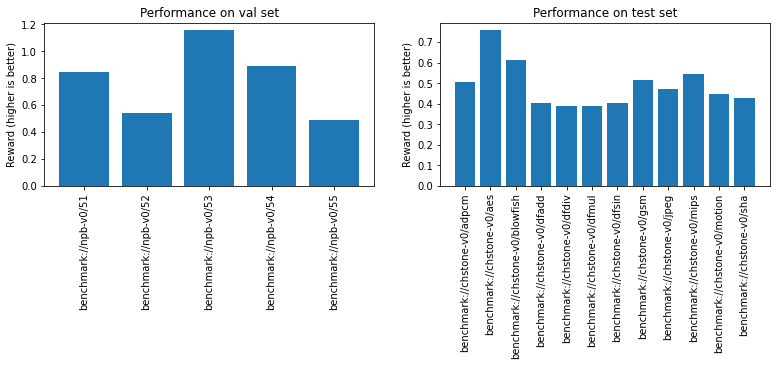

In [11]:
# Finally lets plot our results to see how we did!
from matplotlib import pyplot as plt

def plot_results(x, y, name, ax):
  plt.sca(ax)
  plt.bar(range(len(y)), y)
  plt.ylabel("Reward (higher is better)")
  plt.xticks(range(len(x)), x, rotation = 90)
  plt.title(f"Performance on {name} set")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 3)
plot_results(val_benchmarks, val_rewards, "val", ax1)
plot_results(test_benchmarks, test_rewards, "test", ax2)
plt.show()

That's it for this demonstration! Check out the [documentation site](https://facebookresearch.github.io/CompilerGym/) for more details, API reference, and more. If you can encounter any problems, please [file an issue](https://github.com/facebookresearch/CompilerGym/issues).